# Create Book-level Representation (Training)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import random
import fasttext as ft
import pickle
from sklearn.model_selection import train_test_split

In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, save_model
from tensorflow.keras import models
from tensorflow.keras.utils import plot_model
from model import *

In [4]:
np.random.seed(1)
tf.random.set_seed(1)

## Load Data

In [8]:
text_hist_pd = pd.read_csv('data/text_hist_perm.csv.bz', sep='\t', compression='bz2')
text_hist_pd.shape

(33600, 5)

In [10]:
text_hist_pd.sample(3, random_state=1)

,book1,book2,book3,book4,label
17402,深い 霧 の たちこめる 漆 の 海 姿 なき 幽霊 船長 ゴースト キャプテン が 舵 を...,アイスダンス ペア 樹里 と 恵 は 初 出場 し 界 選手権 大会 で 大 喝采 を 浴び...,そろそろ 考え ちゃ 悩め ブタ シッタカブッタ は 人生 の 見え 方 を ていねい に ...,なぞなぞ 大好き の 妖怪 たち が 読者 に おもしろい なぞなぞ で いどみ 人気 の ...,1700233
9348,宗教 と は 国 と は 人間 へ の 深い まなざし が 捉え 青春 小説 の 新 境地 ...,わたし じゃ よ わ ー ん わ ー ん 学校 から の 帰り道 大きな 声 て い 清香 ...,担任 に 納得 の いか 絵 を 描か さ れ ユク は 傷つく 憧れ の 少女 に 励まさ...,ひな まつり に 愛花 の 家 で は お ばあちゃん だけ が つくれる ごちそう 肉まん...,1902265
32139,夜 の 星空 を 見 げた とき に 学校 で 習っ 星座 が 星座 の 名前 の 通り に...,界 の カエル と 日本 の カエル 200 種類 を カラー 写真 で 紹介 分布 や す...,現在 もっとも 謎 の 多い チョウ モンシロチョウ 最新 の 撮影 技術 と 研究 成果 ...,ほ 類 は虫類 ペット 家 ちく アニマル ウォッチング 絶滅 危機 動物 とじこみ 付録 ...,1400121


## Split into Train and Val

In [12]:
train_texts, val_texts, y_train, y_val = train_test_split(text_hist_pd.drop(['label'], axis=1),
                                                          text_hist_pd[['label']].values,
                                                          test_size = .2,
                                                          random_state=1234)

## Tokenize

In [13]:
# Limit on the number of word features to the top 20K features.
TOP_K = 20000

# Most claims doc are within 10K word length
MAX_SEQUENCE_LENGTH = 500

def sequence_vectorize(train_texts, y_train, val_texts, y_val):
    # Create vocabulary with training texts.
    tokenizer = Tokenizer(num_words=TOP_K)
    tokenizer.fit_on_texts(train_texts['book1'])

    # Vectorize training and validation texts.
    # Fix sequence length to max value. Sequences shorter than the length are
    # padded in the beginning and sequences longer are truncated
    # at the beginning.
    x_trn_1 = pad_sequences(tokenizer.texts_to_sequences(train_texts['book1']), maxlen=MAX_SEQUENCE_LENGTH)
    x_trn_2 = pad_sequences(tokenizer.texts_to_sequences(train_texts['book2']), maxlen=MAX_SEQUENCE_LENGTH)
    x_trn_3 = pad_sequences(tokenizer.texts_to_sequences(train_texts['book3']), maxlen=MAX_SEQUENCE_LENGTH)
    x_trn_4 = pad_sequences(tokenizer.texts_to_sequences(train_texts['book4']), maxlen=MAX_SEQUENCE_LENGTH)
    x_val_1 = pad_sequences(tokenizer.texts_to_sequences(val_texts['book1']), maxlen=MAX_SEQUENCE_LENGTH)
    x_val_2 = pad_sequences(tokenizer.texts_to_sequences(val_texts['book2']), maxlen=MAX_SEQUENCE_LENGTH)
    x_val_3 = pad_sequences(tokenizer.texts_to_sequences(val_texts['book3']), maxlen=MAX_SEQUENCE_LENGTH)
    x_val_4 = pad_sequences(tokenizer.texts_to_sequences(val_texts['book4']), maxlen=MAX_SEQUENCE_LENGTH)
    
    return x_trn_1, x_trn_2, x_trn_3, x_trn_4, x_val_1, x_val_2, x_val_3, x_val_4, tokenizer.word_index, tokenizer

In [14]:
x_trn_1, x_trn_2, x_trn_3, x_trn_4, x_val_1, x_val_2, x_val_3, x_val_4, word_index, tokenizer = sequence_vectorize(train_texts, y_train, val_texts, y_val)

In [15]:
# number of vocabulary in the corpus
len(word_index)

13505

### Load FastText (Japanese)

In [16]:
ja_vecs = ft.load_model('model/cc.ja.300.bin')

In [17]:
ja_vecs.get_word_vector('あ').shape

(300,)

In [18]:
EMBEDDING_DIM = 300

## Use mean of FastText vectors as label

In [20]:
label_vec_dict = np.load('data/label_vec_dict.npy', allow_pickle=True).tolist()

In [21]:
y_train_mean = []
for book_id in y_train:
    y_train_mean.append(label_vec_dict[int(book_id[0])])

y_train_mean = np.array(y_train_mean)

In [22]:
np.save('data/y_train_mean.npy', y_train_mean)

In [23]:
y_val_mean = []
for book_id in y_val:
    y_val_mean.append(label_vec_dict[int(book_id[0])])

y_val_mean = np.array(y_val_mean)

In [24]:
np.save('data/y_val_mean.npy', y_val_mean)

In [25]:
y_train.shape, y_train_mean.shape, y_val.shape, y_val_mean.shape

((26880, 1), (26880, 300), (6720, 1), (6720, 300))

## Model

### Embedding layer

In [26]:
embedding_matrix = np.zeros((TOP_K+1, EMBEDDING_DIM))
for word, i in word_index.items():
    if i < TOP_K:
        try:
            embedding_vector = ja_vecs.get_word_vector(word)
        except:
            embedding_vector = np.zeros(EMBEDDING_DIM)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector

### Train Model

In [27]:
learning_rate=0.0026

word_id_1 = Input(shape=(None,))
word_id_2 = Input(shape=(None,))
word_id_3 = Input(shape=(None,))
word_id_4 = Input(shape=(None,))

max_sequence = x_trn_1.shape[1] if MAX_SEQUENCE_LENGTH > x_trn_1.shape[1] else MAX_SEQUENCE_LENGTH

model = gru_model(
                     embedding_dim=EMBEDDING_DIM,
                     dropout_rate=0.226,
                     rnn_unit=196,
                     input_shape=(max_sequence,),
                     num_features=TOP_K+1,
                     share_gru_weights_on_book=True,
                     use_attention_on_book=False,
                     use_attention_on_user=True,
                     use_batch_norm=False,
                     is_embedding_trainable=False,
                     final_activation='tanh',
                     embedding_matrix=embedding_matrix)

# Compile model
loss = 'cosine_similarity'

optimizer = Adam(lr=learning_rate)
model.compile(optimizer=optimizer, loss=loss, metrics=['cosine_similarity'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

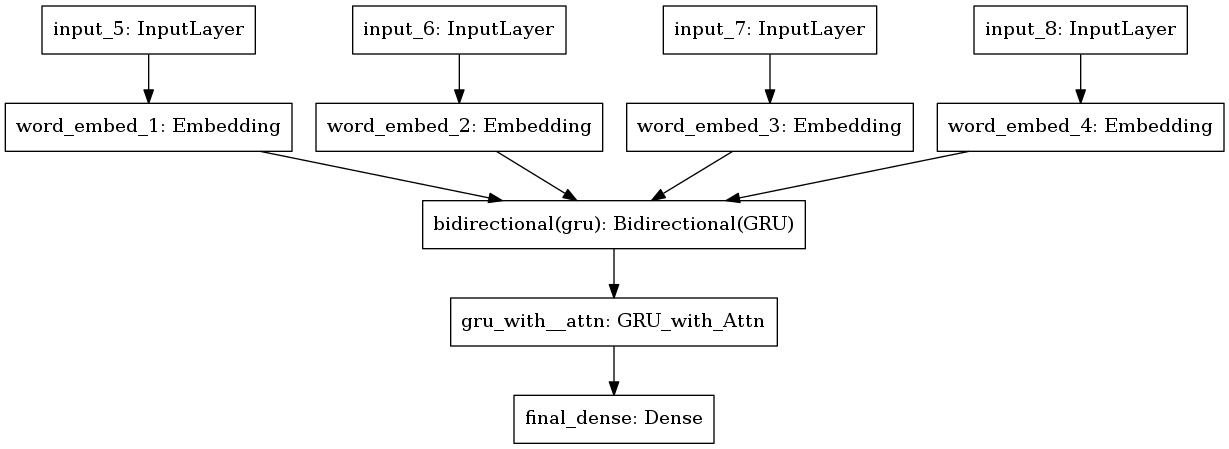

In [28]:
plot_model(model, to_file='img/tosho_book_model.png')

In [29]:
# Train
history = model.fit(
        [x_trn_1, x_trn_2, x_trn_3, x_trn_4],
        y_train_mean,
        epochs=2,
        validation_data=([x_val_1, x_val_2, x_val_3, x_val_4], y_val_mean),
        verbose=1,
        batch_size=256)

Train on 26880 samples, validate on 6720 samples
Epoch 1/2
26880/26880 [==============================] - 409s 15ms/sample - loss: -0.9332 - cosine_similarity: 0.9332 - val_loss: -0.9635 - val_cosine_similarity: 0.9635
Epoch 2/2
26880/26880 [==============================] - 343s 13ms/sample - loss: -0.9644 - cosine_similarity: 0.9644 - val_loss: -0.9691 - val_cosine_similarity: 0.9691


In [30]:
model.save_weights('model/tosho_book_model_1', save_format='tf')

In [31]:
# Train
history2 = model.fit(
        [x_trn_1, x_trn_2, x_trn_3, x_trn_4],
        y_train_mean,
        epochs=2,
        validation_data=([x_val_1, x_val_2, x_val_3, x_val_4], y_val_mean),
        verbose=1,
        batch_size=256)

Train on 26880 samples, validate on 6720 samples
Epoch 1/2
26880/26880 [==============================] - 347s 13ms/sample - loss: -0.9688 - cosine_similarity: 0.9688 - val_loss: -0.9736 - val_cosine_similarity: 0.9736
Epoch 2/2
26880/26880 [==============================] - 340s 13ms/sample - loss: -0.9726 - cosine_similarity: 0.9726 - val_loss: -0.9773 - val_cosine_similarity: 0.9773


In [32]:
model.save_weights('model/tosho_book_model_2', save_format='tf')

In [33]:
# Train
history3 = model.fit(
        [x_trn_1, x_trn_2, x_trn_3, x_trn_4],
        y_train_mean,
        epochs=2,
        validation_data=([x_val_1, x_val_2, x_val_3, x_val_4], y_val_mean),
        verbose=1,
        batch_size=256)

Train on 26880 samples, validate on 6720 samples
Epoch 1/2
26880/26880 [==============================] - 337s 13ms/sample - loss: -0.9755 - cosine_similarity: 0.9755 - val_loss: -0.9795 - val_cosine_similarity: 0.9795
Epoch 2/2
26880/26880 [==============================] - 348s 13ms/sample - loss: -0.9775 - cosine_similarity: 0.9775 - val_loss: -0.9813 - val_cosine_similarity: 0.9813


In [34]:
model.save_weights('model/tosho_book_model_3', save_format='tf')

In [35]:
# Train
history4 = model.fit(
        [x_trn_1, x_trn_2, x_trn_3, x_trn_4],
        y_train_mean,
        epochs=2,
        validation_data=([x_val_1, x_val_2, x_val_3, x_val_4], y_val_mean),
        verbose=1,
        batch_size=256)

Train on 26880 samples, validate on 6720 samples
Epoch 1/2
26880/26880 [==============================] - 349s 13ms/sample - loss: -0.9791 - cosine_similarity: 0.9791 - val_loss: -0.9826 - val_cosine_similarity: 0.9826
Epoch 2/2
26880/26880 [==============================] - 342s 13ms/sample - loss: -0.9804 - cosine_similarity: 0.9804 - val_loss: -0.9837 - val_cosine_similarity: 0.9837


In [36]:
model.save_weights('model/tosho_book_model_4', save_format='tf')

In [ ]:
# Train
history5 = model.fit(
        [x_trn_1, x_trn_2, x_trn_3, x_trn_4],
        y_train_mean,
        epochs=2,
        validation_data=([x_val_1, x_val_2, x_val_3, x_val_4], y_val_mean),
        verbose=1,
        batch_size=256)

Train on 26880 samples, validate on 6720 samples
Epoch 1/2
26880/26880 [==============================] - 337s 13ms/sample - loss: -0.9813 - cosine_similarity: 0.9813 - val_loss: -0.9846 - val_cosine_similarity: 0.9846
Epoch 2/2
26624/26880 [============================>.] - ETA: 2s - loss: -0.9821 - cosine_similarity: 0.9821

In [43]:
train_metrics = 'cosine_similarity'
train_metrics_concat = history.history[train_metrics] + history2.history[train_metrics] + history3.history[train_metrics] + history4.history[train_metrics] + history5.history[train_metrics] 
val_metrics = 'val_cosine_similarity'
val_metrics_concat = history.history[val_metrics] + history2.history[val_metrics] + history3.history[val_metrics] + history4.history[val_metrics] + history5.history[val_metrics] 

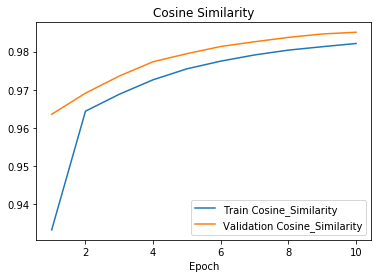

In [51]:
epoch_list = [i+1 for i in range(10)]

plt.figure(figsize = (6, 4))
plt.plot(epoch_list, train_metrics_concat, label='Train Cosine_Similarity')
plt.plot(epoch_list, val_metrics_concat, label='Validation Cosine_Similarity')
plt.title('Cosine Similarity')
plt.xlabel('Epoch')
plt.legend()
plt.show();

### Save Objects

In [53]:
def save_object(obj, filename):
    with open(filename, 'wb') as output:
        pickle.dump(obj, output, protocol=2)

save_object(word_index, 'model/tosho_book_model_word_index.pkl')
save_object(tokenizer, 'model/tosho_book_model_word_tokenizer.pkl')

## Extract Intermediary Layer for Book-level Representation

In [54]:
layer_outputs = [layer.output for layer in model.layers[:-2]]

In [55]:
layer_outputs

[<tf.Tensor 'input_5:0' shape=(None, None) dtype=float32>,
 <tf.Tensor 'input_6:0' shape=(None, None) dtype=float32>,
 <tf.Tensor 'input_7:0' shape=(None, None) dtype=float32>,
 <tf.Tensor 'input_8:0' shape=(None, None) dtype=float32>,
 <tf.Tensor 'word_embed_1/Identity:0' shape=(None, None, 300) dtype=float32>,
 <tf.Tensor 'word_embed_2/Identity:0' shape=(None, None, 300) dtype=float32>,
 <tf.Tensor 'word_embed_3/Identity:0' shape=(None, None, 300) dtype=float32>,
 <tf.Tensor 'word_embed_4/Identity:0' shape=(None, None, 300) dtype=float32>,
 <tf.Tensor 'bidirectional/Identity:0' shape=(None, 392) dtype=float32>]

In [56]:
book_representation_model = models.Model(inputs=model.input, outputs=layer_outputs[-1])

In [57]:
save_model(book_representation_model, 'model/tosho_book_representation.hdf5')